# Importing the required libraries

In [1]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Check on which device pytorch is running

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading the data from dataset

In [3]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"
valid_dir = "./dataset/val"

CLASS_NAMES = next(os.walk(train_dir))[1]
NUM_CLASSES = len(CLASS_NAMES)

print("Path Directory: ", os.listdir("./dataset"))
print("Train Directory:", os.listdir(train_dir))
print("valid Direcory: ", os.listdir(valid_dir))
print("Test Directory: ", os.listdir(test_dir))

print("Number of classes: ", NUM_CLASSES)

Path Directory:  ['data_splitting.py', 'test', 'train', 'train.cache', 'val', 'val.cache']
Train Directory: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
valid Direcory:  ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Test Directory:  ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of classes:  5


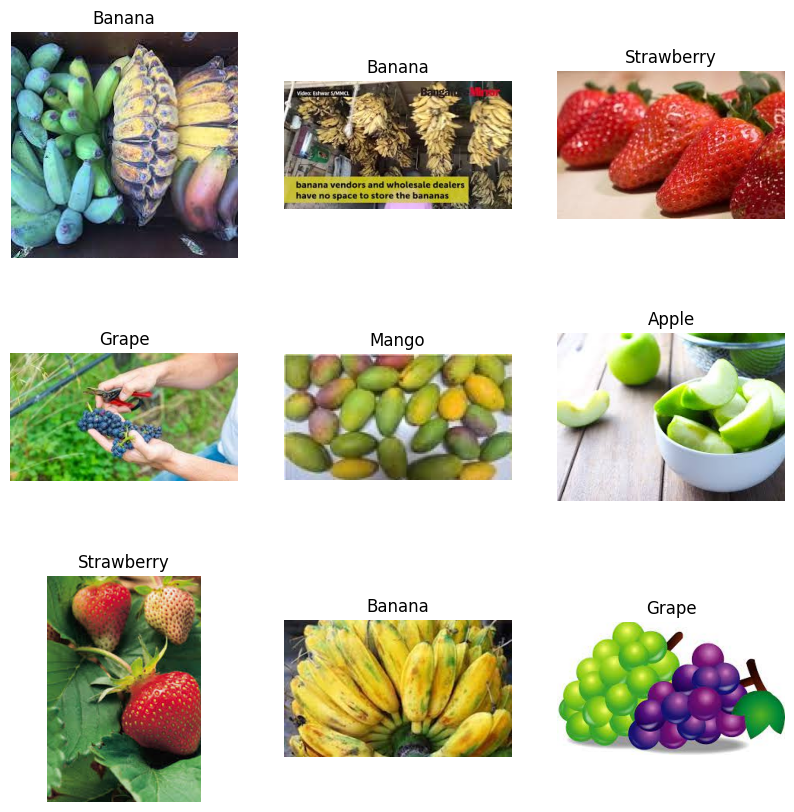

In [4]:
# Function to show random images from training dataset

def show_random_images(data_dir, num_images):
    class_names = os.listdir(data_dir)
    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i in range(num_rows):
        for j in range(num_cols):
            class_num = random.randint(0, len(class_names)-1)
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)
            img = mpimg.imread(img_path)
            axarr[i, j].imshow(img, cmap = 'gray')
            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')
            
    plt.show()

show_random_images(train_dir, 9)

# Image Preprocessing

In [5]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),

    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [6]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, transform=image_transforms['test'])
}

print("Training data: ", len(data['train']))
print("Validation data: ", len(data['valid']))
print("Test data: ", len(data['test']))

Training data:  9700
Validation data:  200
Test data:  100


In [7]:
BATCH_SIZE = 32

train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data['test'], batch_size=BATCH_SIZE, shuffle=True)

# Loading pretrainded model

In [8]:
# Loading Pretrained Weights of VGG16
model = models.vgg16(pretrained = True).to(device)
summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Marcin/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:17<00:00, 32.4MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Building and Training Model

In [9]:
# Freeze all layers except the last one
for param in model.classifier.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

# Transfer the model to device
model = model.to(device)

### Define loss function and optimizer

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

### Training loop

In [11]:
num_epochs = 5
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Training loop
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy /= len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    
        # Validation loop
    model.eval()
    for images, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        valid_accuracy += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)
    valid_accuracy /= len(valid_loader.dataset)
    valid_accuracies.append(valid_accuracy)
    
    # Print training and validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}')


Validation Epoch 1/5: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


Epoch [1/5], Train Loss: 1.5907, Valid Loss: 1.5151, Train Accuracy: 0.2549, Valid Accuracy: 0.6150


Validation Epoch 2/5: 100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


Epoch [2/5], Train Loss: 1.3622, Valid Loss: 0.9506, Train Accuracy: 0.4575, Valid Accuracy: 0.6350


Validation Epoch 3/5: 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]


Epoch [3/5], Train Loss: 1.0398, Valid Loss: 0.7403, Train Accuracy: 0.5984, Valid Accuracy: 0.7300


Validation Epoch 4/5: 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]


Epoch [4/5], Train Loss: 0.9268, Valid Loss: 0.7281, Train Accuracy: 0.6482, Valid Accuracy: 0.6900


Validation Epoch 5/5: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

Epoch [5/5], Train Loss: 0.8674, Valid Loss: 0.6824, Train Accuracy: 0.6737, Valid Accuracy: 0.7450


# Test the model on test dataset

In [12]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Testing: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

Test Accuracy of the model on the test images: 85.0 %


### Plot confusion matrix

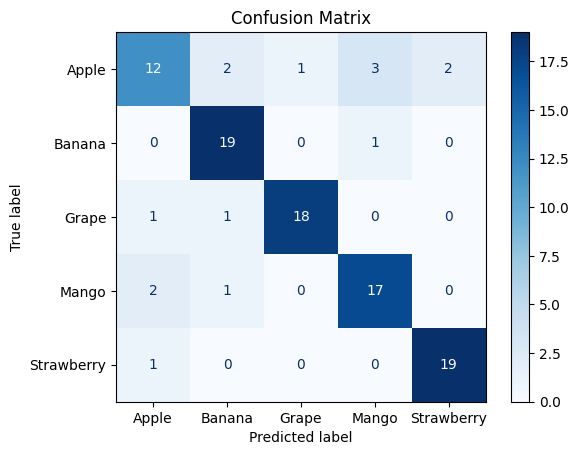

              precision    recall  f1-score   support

       Apple       0.75      0.60      0.67        20
      Banana       0.83      0.95      0.88        20
       Grape       0.95      0.90      0.92        20
       Mango       0.81      0.85      0.83        20
  Strawberry       0.90      0.95      0.93        20

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



In [13]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Plot loss curves

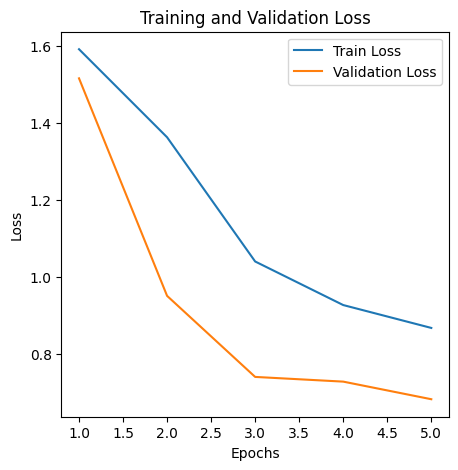

In [14]:
# Plotting loss curves
plt.figure(figsize=(5, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy curves

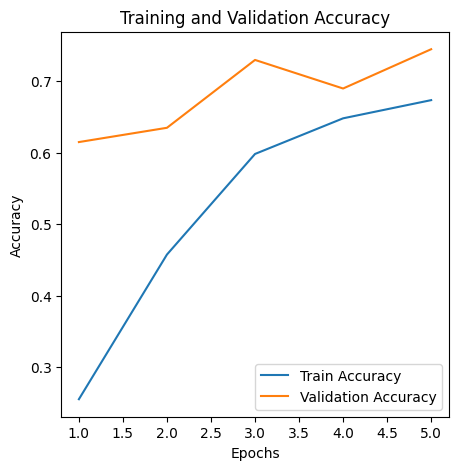

In [15]:
# Plotting accuracy curves
plt.figure(figsize=(5, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()